# Project 2

## Topic : Stereo reconstruction and Non-linear optimization

#### Instructions
<ul>
    <li> The second project of the course is designed to get you familiar with stereo reconstruction, and non-linear optimization </li>
    <li> Use python for this project. PILLOW and OpenCV are permitted for image I/O. </li>
    <li> Submit this notebook as a zipped file on moodle. The format should be $<$team_id$>$_$<$team_ name$>$.zip. Both members have to submit this zip file. </li>
    <li> A seperate report is not needed if you're coding in the notebook itself. Please provide adequate descriptions of the approaches you've taken. Also mention work distribution for the two members. </li>
    <li> Refer to the late day policy. Start early </li> 
    <li> Download data from here: https://iiitaphyd-my.sharepoint.com/:f:/g/personal/aryan_sakaria_students_iiit_ac_in/Er5C7351IAlFsvwHUesFeSQBQtlSiAS7AORSEJT2qH_8_w?e=ol98k9  </li>
</ul>

----
### PART 1: Stereo dense reconstruction

3-D point clouds are very useful in robotics for several tasks such as object detection, motion estimation (3D-3D matching or 3D-2D matching), SLAM, and other forms of scene understanding.  Stereo camerasprovide  us  with  a  convenient  way  to  generate  dense  point  clouds.Densehere,  in  contrast  tosparse,means all the image points are used for the reconstruction.  In this part of the assignment you will begenerating a dense 3D point cloud reconstruction of a scene from stereo images.

#### Procedure: 

<ol>
    <li> Generate a disparity map for each stereo pair.  Use OpenCV (e.g.  StereoSGBM) for this.  Notethat the images provided are already rectified and undistorted. </li>
    <li> Then, using the camera parameters and baseline information generate colored point clouds fromeach disparity map.  Some points will have invalid disparity values, so ignore them.  Use [Open3D]for storing your point clouds. </li>
    <li> Register (or transform) all the generated point clouds into your world frame by using the providedground truth poses. </li>
    <li> Visualize the registered point cloud data, in color.  Use Open3D for this </li>
</ol>
    

In [1]:
#import libraries:
import numpy as np 
# from sklearn.preprocessing import normalize #normalizing gives better results. Experiment with this
import cv2
import open3d as o3d
import matplotlib.pyplot as plt
import glob
import os
import math

In [2]:
def read_transformations(filename='mr2020_project_data/poses.txt'):
    f = open(filename, 'r')
    lines = f.readlines()
    transformation_list = []
    for i in range(len(lines)):
        transformation_list_temp = lines[i].split()
        temp_rot = [] 
        temp_rot.append( (transformation_list_temp[0:4] ) ) 
        temp_rot.append( (transformation_list_temp[4:8]  ) ) 
        temp_rot.append( (transformation_list_temp[8:12]  ) ) 
        transformation_list.append(temp_rot)
    return transformation_list

Provide explanation in this cell: 
1. `calc_disparity()` takes a pair of stereo images as its input and calculates the disparity map using the inbuilt function `cv2.StereoSGBM_create()`.
2. To generate a point cloud from the disparity map, we use the formula  
$$
depth = \frac{(baseline * f)}{disparity}
$$
where  𝑓  is the focal length (the focal length is the top-left element of the matrix K). We calculate the `depth` value for each pixel using this formula, skipping the pixels with an undefined disparity value which greater minimum disparity. This process projects the points to the camera frame.
3. We read the provided ground truth poses (`poses.txt`), so that we can transform the generated point clouds to the world frame.
4. Using `save_point_cloud()`, saving point clouds for all the stereo image pairs and using `display_point_cloud()` visualizing the registered point cloud data in color.

In [3]:
'''
def calc_disparity(im1, im2):
    window_size = 9
    minDisparity = 10
    stereo = cv2.StereoSGBM_create(
        blockSize=10,
        numDisparities=64,
        preFilterCap=10,
        minDisparity=minDisparity,
        P1=4 * 3 * window_size ** 2,
        P2=32 * 3 * window_size ** 2
    )
    disparity = stereo.compute(im1, im2).astype(np.float32) / 16.0
    #disparity = disparity / stereo.getNumDisparities()
    return disparity
'''
def calc_disparity(im1, im2):
    window_size = 3
    min_disp = 16
    num_disp = 112-min_disp
    stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
        numDisparities = num_disp+(2) * 16,
        blockSize = 7,
        P1 = 8*3*window_size**2,
        P2 = 32*3*window_size**2,
        disp12MaxDiff = 1,
        uniquenessRatio = 12,
        speckleWindowSize = 400,
        speckleRange = 5
    )
    disparity_map = stereo.compute(im1, im2).astype(np.float32) / 16.0
    return disparity_map

def calc_points(im1, disp, K, Kinv, baseline):
    np_points = []
    np_colors = []
    min_disp = disp.min()
    for i in range(im1.shape[0]):
        for j in range(im1.shape[1]):
            if disp[i,j] > min_disp:
                depth = (baseline * K[0][0]) / disp[i, j]
                cameraPosition = Kinv @ np.array([[depth*j], [depth*i], [depth]])
                np_points.append(cameraPosition.flatten())
                np_colors.append(im1[i,j]/255.0)

    return np.array(np_points), np.array(np_colors)

def calc_points_2(im1, disp, K, Kinv, baseline):
    np_points = []
    np_colors = []
    h, w = im1.shape[:2]
    Q = np.float32([[1, 0, 0, -0.5*w],
                    [0,-1, 0,  0.5*h], 
                    [0, 0, 0, -K[0][0]], 
                    [0, 0, -1/baseline,  0]])
    min_disp = disp.min()
    for i in range(im1.shape[0]):
        for j in range(im1.shape[1]):
            if disp[i,j] > min_disp:
                depth = (baseline * K[0][0]) / disp[i, j]
                cameraPosition = Q @ np.array([i, j, disp[i][j]/16.0, 1]).T
                W = cameraPosition[3]
                to_ap = np.array([cameraPosition[0]/W, cameraPosition[1]/W, cameraPosition[2]/W])
                np_points.append(to_ap.flatten())
                np_colors.append(im1[i,j]/255.0)

    return np.array(np_points), np.array(np_colors)

def save_point_cloud(np_points, np_colors, fileName):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np_points)
    pcd.colors = o3d.utility.Vector3dVector(np_colors)
    o3d.io.write_point_cloud(fileName, pcd)
    # o3d.io.write_point_cloud("/content/drive/My Drive/MR/points.pcd", pcd)
    #save_point_cloud(np_points, np_colors, "./points.pcd")

def display_point_cloud(fileName):
    pcd = o3d.io.read_point_cloud(fileName)
    o3d.visualization.draw_geometries([pcd])
    
def transform_pose(points, M):
    points = np.hstack((points, np.ones((points.shape[0], 1))))
    points = (M @ points.T).T
    points = points[:,0:3] / points[:,3,np.newaxis]
    return points

def get_calib_info(datapath):
    f = open(datapath + '/calib.txt', 'r')
    file_contents = f.read()
    #print(file_contents)
    K = [[7.070912e+02, 0.000000e+00, 6.018873e+02],
         [0.000000e+00, 7.070912e+02, 1.831104e+02],
         [0.000000e+00, 0.000000e+00, 1.000000e+00]]
    baseline = 0.53790448812
    Kinv = np.linalg.pinv(K)
    return K, Kinv, baseline

def get_poses():
    content = read_transformations()
    content = np.array(content)
    content = content.astype('float64')
    content = [np.vstack((x, np.array([0,0,0,1]))) for x in content]
    poses = np.array(content)
    return poses

def convert_world_frame(pcd):
        #R = np.array([[0,0,1],[0,-1,0],[1,0,0]])
        R = np.array([[-1,0,0],[0,-1,0],[0,0,1]])
        data = np.asarray(pcd.points)
        data = rotate(R, data)
        color = np.asarray(pcd.colors)
        #color = rotate(R, color)
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(data)
        pcd.colors = o3d.utility.Vector3dVector(color)
        return pcd
    

def rotate(R, points):
        return (R @ points.T).T

def get_pcd(points, colors):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    return pcd

def get_images(datapath):
    im1Names = []
    im2Names = []
    
    for filename in glob.glob(datapath + '/img2/*.png'):
        im1Names.append(filename)
    for filename in glob.glob(datapath + '/img3/*.png'):
        im2Names.append(filename)
    im1Names.sort()
    im2Names.sort()
    
    images1 = []
    images2 = []
    
    for filename in im1Names:
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images1.append(img)
        
    for filename in im2Names:
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images2.append(img)
        
    return images1, images2
        
def main(datapath):
    images1, images2 = get_images(datapath)
    
    all_points = np.zeros((0, 3))
    all_colors = np.zeros((0, 3))
    
    K, Kinv, baseline = get_calib_info(datapath)
    print("K : \n", K)
    print("Baseline : ", baseline)
    poses = get_poses()
    for i in range(len(images1)):
        disp = calc_disparity(images1[i], images2[i])
        cur_points, cur_colors = calc_points(images1[i], disp, K, Kinv, baseline)
        cur_points = transform_pose(cur_points, poses[i])
        print('File {} processed....'.format(i+1))
        all_points = np.vstack((all_points, cur_points))
        all_colors = np.vstack((all_colors, cur_colors))
        
        
    pcd = get_pcd(all_points, all_colors)
    pcd = convert_world_frame(pcd)
    #save_point_cloud(all_points, all_colors, "./all_points.pcd")
    o3d.io.write_point_cloud("./reconstructed_points.pcd", pcd)
    
    return all_points, all_colors

In [4]:
datapath = './mr2020_project_data'
points3d, point_color = main(datapath)
display_point_cloud("./reconstructed_points.pcd")

K : 
 [[707.0912, 0.0, 601.8873], [0.0, 707.0912, 183.1104], [0.0, 0.0, 1.0]]
Baseline :  0.53790448812
File 1 processed....
File 2 processed....
File 3 processed....
File 4 processed....
File 5 processed....
File 6 processed....
File 7 processed....
File 8 processed....
File 9 processed....
File 10 processed....
File 11 processed....
File 12 processed....
File 13 processed....
File 14 processed....
File 15 processed....
File 16 processed....
File 17 processed....
File 18 processed....
File 19 processed....
File 20 processed....
File 21 processed....


Text(0.5, 1.0, 'Sample Output 3')

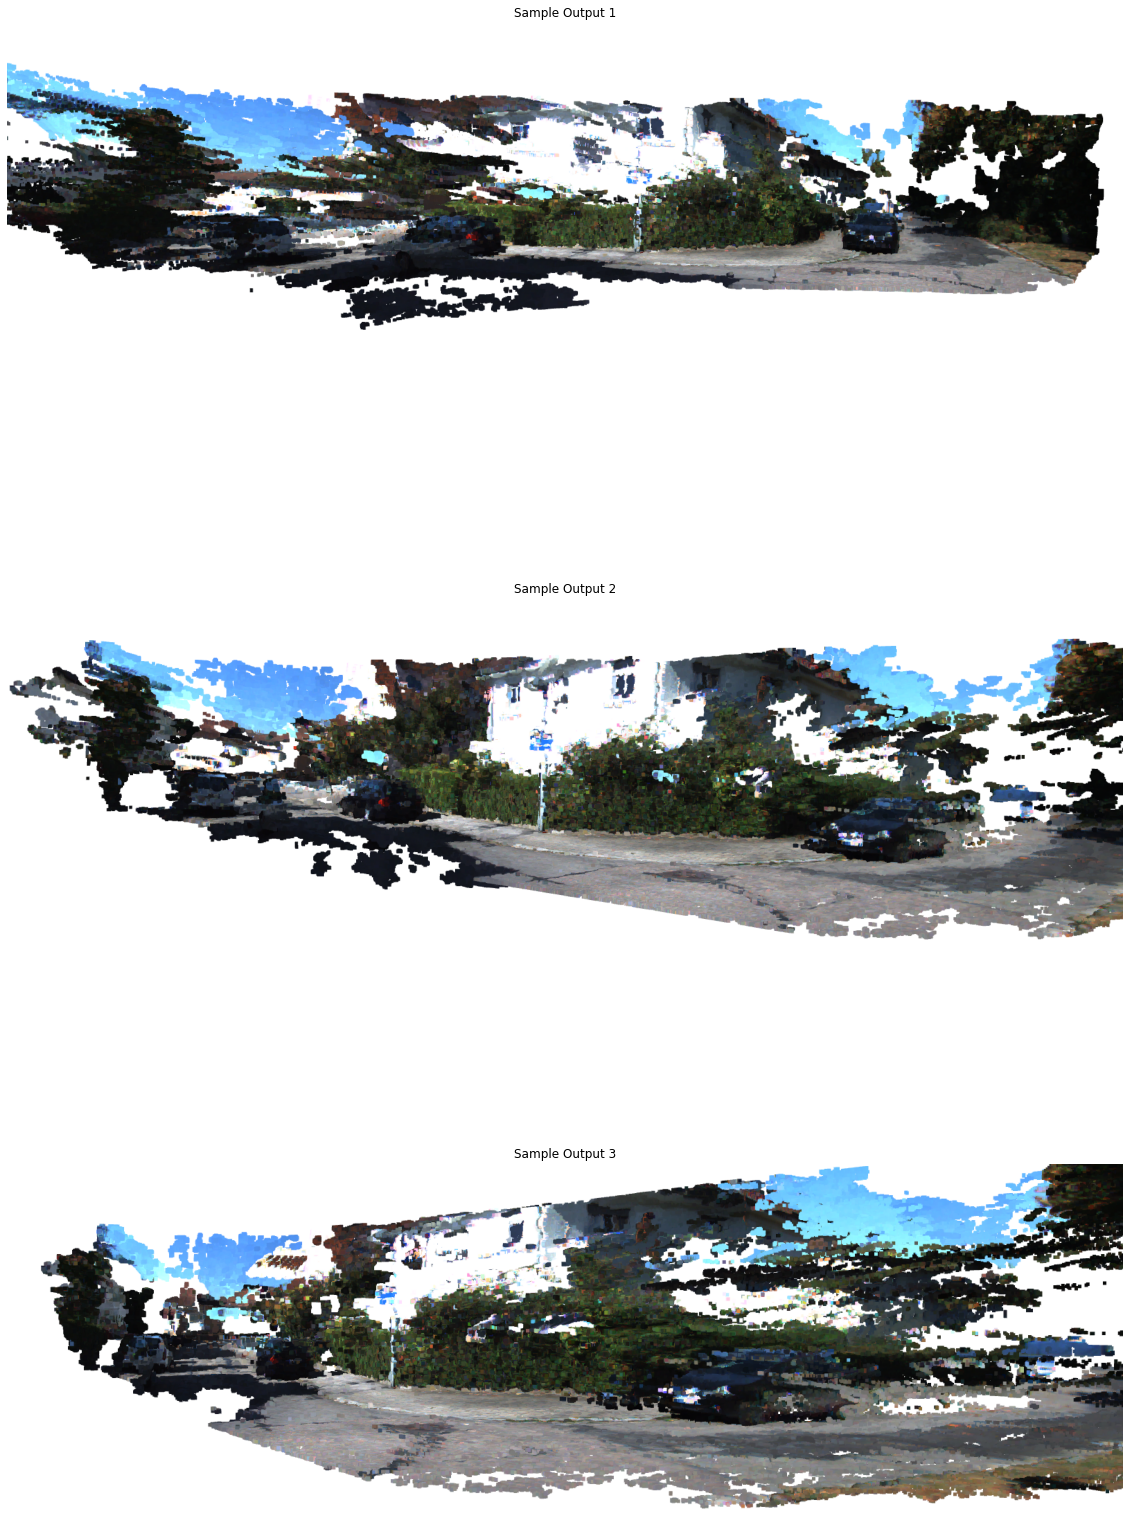

In [5]:
im1 = cv2.imread('output1.PNG')
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
im2 = cv2.imread('output2.PNG')
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
im3 = cv2.imread('output3.PNG')
im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,30))
ax1.imshow(im1)
ax1.axis('off')
ax1.set_title('Sample Output 1')
ax2.imshow(im2)
ax2.axis('off')
ax2.set_title('Sample Output 2')
ax3.imshow(im3)
ax3.axis('off')
ax3.set_title('Sample Output 3')

----
### PART 2: Motion estimation using iterative PnP

Using the generated reconstruction from the previous part, synthesize a new image taken by a virtualmonocular camera fixed at any arbitrary position and orientation.  Your task in this part is to recoverthis pose using an iterative Perspective-from-n-Points (PnP) algorithm. 

#### Procedure: 

<ol>
    <li> Obtain a set of 2D-3D correspondences between the the image and the point cloud.  Since hereyou’re generating the image, this should be easy to obtain. </li>
    <li> For this set of correspondences compute the total reprojection error c= $\sum_{i} ‖x_i−P_{k}X_i‖^2 $    where $P_{k}= K[R_{k}|t_{k}]$, $X_{i}$ is the 3D point in the world frame, $x_{i}$ is its corresponding projection. </li>
    <li> Solve for the pose $T_{k}$ that minimizes this non-linear reprojection error using a Gauss-Newton (GN)scheme.  Recall that in GN we start with some initial estimated value $x_{o}$ and iteratively refine the estimate using $x_{1}$= $∆x+x_0$, where $∆x$ is obtained by solving the normal equations $J^{T}J∆x$= -$J^{T}e$, until convergence.The main steps in this scheme are computing the corresponding Jacobians and updating the estimates correctly.  For our problem,  use a 12×1 vector parameterization for $T_{k}$(the top 3×4submatrix).  Run the optimization for different choices of initialization and report your observations. </li>
</ol>

For estimating the pose, 

__Algorithm__:  

While($Squared\_Error > Threshold\_Squared\_Error$):  
1. Compute $J$  
2. Compute $\Delta x = -(J^{T}J)^{-1}J^{T}(e)$  
3. Compute $x_{k+1} = x_k - \Delta x$  
3. Compute $Squared\_Error$  

To implement the above algorithm, the main challenge is to compute the Jacobian (J).

__Computing the Jacobian(J):__

we know that  
  
$$    
    K [R|t] X = \begin{bmatrix}
        f_x && 0 && c_x\\
        0 && f_y && c_y\\
        0 && 0 && 1\\
    \end{bmatrix}
    \begin{bmatrix}
        a_1 && a_2 && a_3 && a_4\\
        a_5 && a_6 && a_7 && a_8\\
        a_9 && a_{10} && a_{11} && a_{12}\\
    \end{bmatrix}
    \begin{bmatrix}
        X_i\\
        Y_i\\
        Z_i\\
        1\\
    \end{bmatrix}=
    \begin{bmatrix}
        f_x(X_ia_1 + Y_ia_2 + Z_ia_3 + a_4)+c_x(X_ia_9 + Y_ia_{10} + Z_ia_{11} + a_{12})\\
        f_y(X_ia_5 + Y_ia_6 + Z_ia_7 + a_8)+c_y(X_ia_9 + Y_ia_{10} + Z_ia_{11} + a_{12})\\
        X_ia_9 + Y_ia_{10} + Z_ia_{11} + a_{12}\\
    \end{bmatrix}
$$

Therefore,

$$    
    \begin{bmatrix}
        x_i\\
        y_i\\
    \end{bmatrix}=
    \begin{bmatrix}
        \frac{f_x(X_ia_1 + Y_ia_2 + Z_ia_3 + a_4)+c_x(X_ia_9 + Y_ia_{10} + Z_ia_{11} + a_{12})}{X_ia_9 + Y_ia_{10} + Z_ia_{11} + a_{12}}\\
        \frac{f_y(X_ia_5 + Y_ia_6 + Z_ia_7 + a_8)+c_y(X_ia_9 + Y_ia_{10} + Z_ia_{11} + a_{12})}{X_ia_9 + Y_ia_{10} + Z_ia_{11} + a_{12}}\\
    \end{bmatrix}
$$

So,

Assuming,

$$
P_1 = f_x(X_ia_1 + Y_ia_2 + Z_ia_3 + a_4)+c_x(X_ia_9 + Y_ia_{10} + Z_ia_{11} + a_{12})  
$$  

$$
P_2 = f_y(X_ia_5 + Y_ia_6 + Z_ia_7 + a_8)+c_y(X_ia_9 + Y_ia_{10} + Z_ia_{11} + a_{12})
$$  
$$
Q = X_ia_9 + Y_ia_{10} + Z_ia_{11} + a_{12}
$$  
$$
F_x = \frac{f_x}{Q}
$$  
$$
F_y = \frac{f_y}{Q}
$$  
$$
C_x = \frac{c_xQ-P_1}{Q^2}
$$  
$$
C_y = \frac{c_yQ-P_2}{Q^2}
$$

for $x_i$ and $y_i$, the jacobian matrix we have are,

$$
J_i = \begin{bmatrix}
    \frac{\partial x_i}{\partial a_1} & \frac{\partial x_i}{\partial a_2} & \frac{\partial x_i}{\partial a_3} & \frac{\partial x_i}{\partial a_4} & \frac{\partial x_i}{\partial a_5} & \frac{\partial x_i}{\partial a_6} & \frac{\partial x_i}{\partial a_7} & \frac{\partial x_i}{\partial a_8} & \frac{\partial x_i}{\partial a_9} & \frac{\partial x_i}{\partial a_{10}} & \frac{\partial x_i}{\partial a_{11}} & \frac{\partial x_i}{\partial a_{12}}\\
\end{bmatrix}_{1\times12}$$  
$$=\begin{bmatrix}
    X_iF_x & Y_iF_x & Z_iF_x & F_x & 0 & 0 & 0 & 0 & X_iC_x & Y_iC_x & Z_iC_x & C_x\\
\end{bmatrix}_{1\times12}
$$

and  

$$
G_i = \begin{bmatrix}
    \frac{\partial y_i}{\partial a_1} & \frac{\partial y_i}{\partial a_2} & \frac{\partial y_i}{\partial a_3} & \frac{\partial y_i}{\partial a_4} & \frac{\partial y_i}{\partial a_5} & \frac{\partial y_i}{\partial a_6} & \frac{\partial y_i}{\partial a_7} & \frac{\partial y_i}{\partial a_8} & \frac{\partial y_i}{\partial a_9} & \frac{\partial y_i}{\partial a_{10}} & \frac{\partial y_i}{\partial a_{11}} & \frac{\partial y_i}{\partial a_{12}}\\
\end{bmatrix}_{1\times12}$$  
$$=\begin{bmatrix}
    0 & 0 & 0 & 0 & X_iF_y & Y_iF_y & Z_iF_y & F_y &  X_iC_y & Y_iC_y & Z_iC_y & C_y\\
\end{bmatrix}_{1\times12}
$$

Now, considering we have N points $(x_1,y_1),(x_2,y_2),...,(x_N,y_N)$, our final Jacobian matrix J will be as follows,

$$
J = \begin{bmatrix}
    J_1\\
    G_1\\
    J_2\\
    G_2\\
    \vdots\\
    J_N\\
    G_N\\
\end{bmatrix}_{2N\times12}
$$

After computing this Jacobian, we simply use it to compute $\Delta x$  as $\Delta x = -(J^{T}J)^{-1}J^{T}(e)$  
Then we use the $\Delta x$ in the update equation as $x_{k+1} = x_k - \Delta x$

In [6]:
def showImage(img, title='Output',figsize=(15,15)):
    fig = plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    
def get_metadata():
    # Calculating correct projection matrix
    datapath = './mr2020_project_data'
    poses = get_poses()
    Rt = poses[1]
    Rt = np.linalg.inv(Rt)
    Rt = Rt[:3, :]
    
    K, Kinv, baseline = get_calib_info(datapath)
    P = np.matmul(K, Rt) # 3x4 matrix 
    print("Correct projection matrix: \n", P)

    # Calculation of point clouds as in above question 1
    images1, images2 = get_images(datapath) 
    all_points = np.zeros((0, 3))
    all_colors = np.zeros((0, 3))
    K, Kinv, baseline = get_calib_info(datapath)
    #poses = get_poses()
    disp = calc_disparity(images1[1], images2[1])
    cur_points, cur_colors = calc_points_2(images1[1], disp, K, Kinv, baseline)
    #print(cur_points.shape, cur_colors.shape)
    
    gpoints = cur_points[np.random.choice(cur_points.shape[0], 10000, replace=False), :]
    #print(gpoints.shape)
    
    # 3D points from the point cloud 
    pts_3d = [] 
    for i in range(len(gpoints)):
        pt_3d = cur_points[i]
        pt_3d = np.append(pt_3d, 1)
        pts_3d.append(pt_3d)
        
    pts_3d = np.array(pts_3d) # 100x4
    #print(pts_3d.shape)
    return P, K, pts_3d

def computeJacobian(K,P,X):
    Jacobian = [[0 for j in range(0,12)] for i in range(0,2*X.shape[0])]
    for i in range(0,X.shape[0]):
        KRt = np.dot(K,np.dot(P,X[i]))
        Xc = (K[0][2]*KRt[2]-KRt[0])/(KRt[2]*KRt[2])
        Yc = (K[1][2]*KRt[2]-KRt[1])/(KRt[2]*KRt[2])
        Fx = K[0][0]/KRt[2]
        Fy = K[1][1]/KRt[2]
        for k in range(0,4):
            Jacobian[2*i][k] = X[i][k]*Fx
            Jacobian[2*i+1][4+k] = X[i][k]*Fy
            Jacobian[2*i][8+k] = X[i][k]*Xc
            Jacobian[2*i+1][8+k] = X[i][k]*Yc
    return np.array(Jacobian)

def projectedPoints(P,X):
    PP = [0 for i in range(0,2*X.shape[0])]
    for i in range(0,X.shape[0]):
        P0X = np.dot(P[0],X[i])
        P1X = np.dot(P[1],X[i])
        P2X = np.dot(P[2],X[i])
        PP[2*i] = P0X/P2X
        PP[2*i+1] = P1X/P2X
    return np.array(PP).T

def computeNegGradient(Jacobian,diff):
    return np.reshape(np.dot(np.dot(np.linalg.inv(np.dot(Jacobian.T,Jacobian)),Jacobian.T),diff),(3,4))

def GaussNewton(Pinit,Pact,K,X):
    P = Pinit
    PPose = np.dot(K,P)
    PactPose = np.dot(K,Pact)
    # Given 3d computing actual 2d points
    pts_2d_act = projectedPoints(PactPose,X)
    diff = pts_2d_act - projectedPoints(PPose,X)
    i = 0
    while(np.dot(diff.T,diff)>0.00001):
        Jacobian = computeJacobian(K,P,X)
        P = P + computeNegGradient(Jacobian,diff)
        PPose = np.dot(K,P)
        diff = pts_2d_act - projectedPoints(PPose,X)
        print("Iteration Number : {}, Reprojection Error : {}".format(i,np.round(np.dot(diff.T,diff), 7)))
        i += 1
    return P


In [7]:
Pinit = np.array([[-8.8e+02,4.4e+01,-2.4e+02,-1.5e+05],
                [-3.6e+01,7.1e+02,-1.4e+02, 2.4e+02],
                [-3.1e-01,3.1e-02,-9.9e-01,-1.9e+01]])
P, K, pts_3d = get_metadata()
P_est = GaussNewton(Pinit,P,K,pts_3d)

print('Original Pose:')
print(P/P[2][3])
print('\nEstimated Pose:')
print(P_est/P_est[2][3])

Correct projection matrix: 
 [[-8.78525339e+02  4.63644532e+01 -2.97135956e+02 -1.48788443e+05]
 [-3.56858055e+01  7.13074879e+02 -1.54136823e+02  2.44991148e+02]
 [-3.69036543e-01  3.75853232e-02 -9.28654584e-01 -1.93732815e+01]]
Iteration Number : 0, Reprojection Error : 3064184458827.0474
Iteration Number : 1, Reprojection Error : 32763210277260.973
Iteration Number : 2, Reprojection Error : 1601443630082.4165
Iteration Number : 3, Reprojection Error : 2099950087457.0059
Iteration Number : 4, Reprojection Error : 16277483704.775543
Iteration Number : 5, Reprojection Error : 114058393.5664358
Iteration Number : 6, Reprojection Error : 4864481.6982123
Iteration Number : 7, Reprojection Error : 394627.3099941
Iteration Number : 8, Reprojection Error : 1024.7023435
Iteration Number : 9, Reprojection Error : 13.7083417
Iteration Number : 10, Reprojection Error : 0.4998314
Iteration Number : 11, Reprojection Error : 0.008142
Iteration Number : 12, Reprojection Error : 0.0002112
Iteration 

__Observation on starting with different initial values:__ 
1. On starting at different initial poses (i.e Pinit in the above code), we see that all the estimated poses P_est are different, but are proportional to each other. After we divide all the elements of the poses by their corresponding $a_{12}$ value (i.e the last element of the pose matrix), we see that all the poses are actually the same. 
2. If the initial position are very far from actual pose, then Gauss Newton would get stuck in local minima. 

# Project 2 - Part B:

## 1. SfM pipeline (`6 mark`)

To get the context of below questions, take a look at the code above: The same questions have been asked at different places above as comments in the code.

1. `0.5 mark` **Basics** - How do we know this (`camera_ind`) information in practical setting? In other words, how do we know observations in `points_2d` belong to which camera. Explain. 
    - Ans-1 - Basics: First we need to know correspondences between images of different views, then we can use Triangulation, triangulation in stereo analysis is the task of computing the 3D position of points in the images, given the disparity map and the geometry of the stereo settings. From given 2D-3D correspondences we estimate the camera parameters (K, R, t) using PnP(for calibrated) or DLT(for uncalibrated) method. Similarly for "n" cameras we estimate their parameters (K, R, t) and record the index of camera in `camera_ind` and store it sequentially the projected pixels in `points_2d` with its corresponding 3d point index in `point_ind`.
    
2. `0.5 mark` **Basics** - How do we know this (`point_ind`) information in practical setting?  In other words, how do we know observations in `points_2d` belong to which 3D point. Explain.
    - Ans-2 - Basics: First we need to know correspondences between images of different views, then we can use Triangulation, triangulation in stereo analysis is the task of computing the 3D position of points in the images, given the disparity map and the geometry of the stereo settings. From given 2D-3D correspondences we estimate the camera parameters (K, R, t) using PnP(for calibrated) or DLT(for uncalibrated) method. Similarly for "n" cameras we estimate their parameters (K, R, t) and record the index of camera in `camera_ind` and store it sequentially the projected pixels in `points_2d` with its corresponding 3d point index in `point_ind`.
    
3. `0.5 mark` **Transformations** - `project()` function: In the `project()` function, would it make any difference if I do translate first, then rotate? Why/why not?
    - Ans-3 - Transformations: Translating first and then rotating does not give the same result as rotating first and then translating. The reason for this is that matrix multiplication is not commutative, which means that `Mtrans × Mrotate ≠ Mrotate × Mtrans`.
    
4. `0.5 mark` **Jacobian** - `bundle_adjustment_sparsity()` function: m above is not "M*N" (*2) unlike our lecture notes. Why is that so?
    - Ans-4 - Jacobian: 2MN is different from 'm' since all 3D points are not visible in all cameras i.e the reason we just do `"2m" (2*n_observations)`.
    
5. `2 mark` **Jacobian & Parameters** - `bundle_adjustment_sparsity()` function: 
    1.  Why are we doing `n_cameras * 9` here instead of `n_cameras * 12`? Recollect: Every individual motion Jacobian was (1*)12 in our lecture notes. 
        - Ans 5.1 - Jacobian & Parameters: In this code we have, `3 rotation, 3 translation, 1 focal distance and 2 distortion parameters` which totals to 9 i.e `9 parameters * n_cameras`. It was 12 earlier because Projection matrix is 3*4 matrix having 12 elements with 11 dof.
        
    2. Ignoring the scale parameters, what was the number of unknown parameters in our lecture notes in terms of `n_cameras` and `n_points`? What is it here in the code? Is it different? If so, what is and why? [Link of notes](https://www.notion.so/Stereo-Structure-from-Motion-9fdd81e4194f4803ac9ba7552df56470).
        - Ans 5.2 - Jacobian & Parameters: In lecture notes unknown parameters eliminating scale parameters is `world points = 3M` and `orientations = 60K`. 
        In above code we have, `n_cameras = 49` and `n_points = 7776` i.e, `total world points = 7776*3 = 23328`, `orientations = 9 * 49 = 441`, therefore `total unknown parameters = 23769`.

6. `2 mark` **Sparsity, Residual Vector & Jacobian** - `bundle_adjustment_sparsity()` function: Explain what you understand from above 6 lines of code by coding a simple toy example yourself to illustrate how it is different from what you've learnt in class. ([Coding toy example + elaborating in words]- both are compulsory.)
    - Ans 6 - Sparsity, Residual Vector & Jacobian: 
        1. `bundle_adjustment_sparsity()` :
             1. It has `rows = 2*n_observations = 2*31843 = 63686` and `column = total_parameters = n_cameras * 9 + n_points * 3 = 23769`. 
             2. For each observation (x,y) point, we differentiate with 9 camera paramters and then differentiating with 3 (3D point) parameter based on point_indices. Total 12 column indices are set to 1 for each point(x,y)
             
             example - 
                 1. for point(0)	cols = (0,1,2,3,4,5,6,7,8,441,442,443) are set to 1.
                 2. for point(1)    cols = (1,2,3,4,5,6,7,8,9,441,442,443) are set to 1 and so on...
             So at a time there will be only 12 column indexes are set 1 for each point(observation).
             
             3. This results matrix A (63686, 23769) to be a sparse matrix.
        
       In lecture notes we have `rows = 2MN and cols = 12M+3N` and here in code we have  `rows = 2M and columns = 9M+3N`

## 2. Initializing R,t and 3D points for SfM given 2 images (`4 mark`)

Using OpenCV functions, mention how you would initialize R,t (poses) and 3D points for SfM given 2 images and K matrix. You don't need to implement it, just mention function names with input/output arguments clearly and briefly explain what they do (You don't need to give detailed answers). A sample answer could be as follows:

**Ans 2:**

1. First, we do feature matching using the following function

    `BFMatcher.knnMatch(desc1, desc2, k)`: It takes descriptors of given 2 images (images) computed using SIFT descriptors to match features and k as input arguments and gives us k best matches as outputs. These outputs are passed to the next step.

2. With OpenCV find the essential matrix via the findEssentialMatrix function as below:

    Mat E = `cv.findEssentialMat(leftPoints, rightPoints, K, focal, pp)`; where focal is focal length , pp is Principal Point and K is camera matrix and given leftPoints are Matching points in the “left” image, rightPoints are in the “right” image and we get E = essential matrix as output.

3. Now that we have essential matrix, we can decompose it into R,t as following:

    `Rt = cv2.recoverPose(E, pts0, pts1, K)`: This takes Essential matrix, K matrix and the corresponding points in 2 images as input arguments and gives us R,t. `Rt[1]` would give us R and `Rt[2]` would give us t.
    It recovers the relative camera rotation and the translation (R,t) from an estimated essential matrix and the corresponding points in two images, using cheirality check. The cheirality check makes sure that all triangulated 3D points are in front of the reconstructed camera. Camera matrix recovery from the essential matrix has four possible solutions, but the only correct solution is the one that will produce triangulated points in front of the camera, hence the need for a cheirality check

4. Now that we have **`K,R,t`**, we find 3D points as follows:
    
    1. We compute Projection Matrix (P):
       
    x = PX where (x, X) are corresponding image and world points. P is a 3x4 dimensional matrix. P can be written as P = K [ R | t] , R = Rotation matrix , t = Translation vector

    Since P is known we get X using above equation ($x = PX$ i.e $P^{-1}x = X$)
    
    2. Then use, `cv.triangulatePoints(projMatr1, projMatr2, projPoints1, projPoints2)` : projMatr1	is 3x4 projection matrix of the first camera, projMatr2	3x4 projection matrix of the second camera, projPoints1 is 2N array of feature points in image 1 and projPoints1 is 2N array of feature points in image 2, the output will be points4D i.e 4xN array of reconstructed points in homogeneous coordinates. These points are returned in the world's coordinate system.

### Contribution
**Ritu** - Calculating the disparity, Open3D visualization, 2D-3D correspondences, Pose estimation using Gauss-Newton algorithm, Project 2 - Part B

**Jeet** - Generation of point cloud from disparity map and transformation to world frame, Pose estimation using Gauss-Newton algorithm and Jacobian, Project 2 - Part B